# Automatic sleep staging

This notebook demonstrates how to perform automatic sleep staging of polysomnography data in YASA. For more details, make sure to read the [eLife publication](https://elifesciences.org/articles/70092).

Please install the latest version of YASA first with: `pip install --upgrade yasa`.

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data loading

The automatic sleep staging function requires that the data are loaded using the [MNE Python package](https://mne.tools/stable/index.html). For instance, if your polysomnography data are stored in the standard European Data Fomat (.edf), you can use [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html?highlight=read_raw_edf#mne.io.read_raw_edf) to load the data into Python.

In [2]:
# Let's load a nap recording, directly as an MNE Raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])
raw

The channels are: ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
The sampling frequency is: 100.0


<Raw | sub-02_mne_raw.fif, 9 x 294000 (2940.0 s), ~20.2 MB, data loaded>

In [3]:
# Let's now load the human-scored hypnogram, where each value represents a 30-sec epoch.
hypno = np.loadtxt('sub-02_hypno_30s.txt', dtype=str)
hypno

array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N1', 'W', 'W', 'W',
       'W', 'N1', 'N1', 'N1', 'W', 'W', 'N1', 'N1', 'N1', 'N1', 'N2',
       'N2', 'N2', 'W', 'N1', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'W',
       'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U2')

## Sleep staging

Automatic sleep stages classification can be done since YASA 0.4.0 using the [SleepStaging](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) class. Make sure to read the [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging), which explains how the algorithm works.

In [4]:
# We first need to specify the channel names and, optionally, the age and sex of the participant
# - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
# - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
# - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
# - "eog_name" is the name of the EOG channel (e.g. EMG1-EMG3). This is optional.
# - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
sls = yasa.SleepStaging(raw, eeg_name="C4", eog_name="EOG1", emg_name="EMG1", metadata=dict(age=21, male=False))

In [5]:
# Getting the predicted sleep stages is now as easy as:
y_pred = sls.predict()
y_pred

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N3', 'N3', 'N3', 'N3', 'N2', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W'], dtype=object)

In [6]:
# What is the accuracy of the prediction, compared to the human scoring
accuracy = (hypno == y_pred).sum() / y_pred.size
print("The overall agreement is %.3f" % accuracy)

The overall agreement is 0.837


**Stage probabilities and confidence of the algorithm at each epoch**

In [7]:
# What are the predicted probabilities of each sleep stage at each epoch?
sls.predict_proba()

,N1,N2,N3,R,W
epoch,,,,,
0,0.002202,0.005040,0.000703,1.875966e-18,0.992055
1,0.003362,0.003284,0.001926,8.279263e-05,0.991345
2,0.004078,0.003225,0.000095,7.688612e-04,0.991833
3,0.001918,0.001771,0.000052,7.023297e-04,0.995557
4,0.002624,0.007565,0.000221,5.963933e-04,0.988994
...,...,...,...,...,...
93,0.004001,0.009041,0.004678,9.823759e-05,0.982182
94,0.001910,0.028894,0.136638,2.746406e-04,0.832283
95,0.001399,0.001958,0.000488,4.246366e-05,0.996112


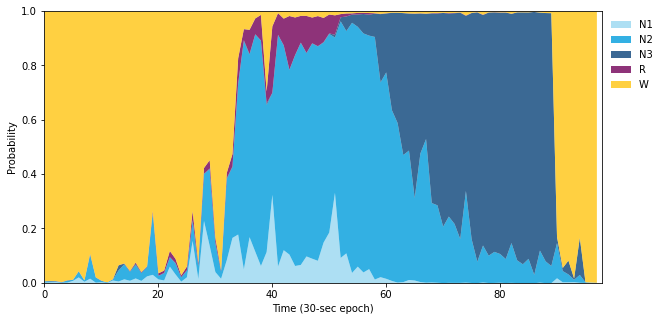

In [8]:
# Plot the predicted probabilities
sls.plot_predict_proba();

In [9]:
# From the probabilities, we can extract a confidence level (ranging from 0 to 1) for each epoch.
confidence = sls.predict_proba().max(1)
confidence

epoch
0     0.992055
1     0.991345
2     0.991833
3     0.995557
4     0.988994
        ...   
93    0.982182
94    0.832283
95    0.996112
96    0.997007
97    0.998046
Length: 98, dtype: float64

**Exporting to a CSV file**

In [10]:
# Let's first create a dataframe with the predicted stages and confidence
df_pred = pd.DataFrame({'Stage': y_pred, 'Confidence': confidence})
df_pred.head(6)

# Now export to a CSV file
# df_pred.to_csv("my_hypno.csv")

,Stage,Confidence
epoch,,
0,W,0.992055
1,W,0.991345
2,W,0.991833
3,W,0.995557
4,W,0.988994
5,W,0.986805


**Applying the detection using only a single EEG derivation**

In [11]:
# Using just an EEG channel (= no EOG or EMG)
y_pred = yasa.SleepStaging(raw, eeg_name="C4").predict()
y_pred

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'N1', 'N2', 'W', 'W', 'N2', 'N2', 'R', 'N2', 'R', 'R',
       'N2', 'R', 'R', 'N2', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3', 'N2', 'N2',
       'N3', 'N2', 'N2', 'N3', 'N2', 'N3', 'N2', 'N2', 'N2', 'N3', 'N3',
       'N3', 'N2', 'N3', 'N2', 'N3', 'N3', 'W', 'N3', 'W', 'W', 'W', 'W',
       'W', 'W'], dtype=object)